<a href="https://colab.research.google.com/github/ParthikB/Vohoo-Tensorflow/blob/master/is_it_a_Cat_or_Dog%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import os

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

##Importing Data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 2s 0us/step


In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')            # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')            # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('Total training cat images    :', num_cats_tr)
print('Total training dog images    :', num_dogs_tr)

print('Total validation cat images  :', num_cats_val)
print('Total validation dog images  :', num_dogs_val)
print("----------------------------------------------")
print("Total training images        :", total_train)
print("Total validation images      :", total_val)

Total training cat images    : 1000
Total training dog images    : 1000
Total validation cat images  : 500
Total validation dog images  : 500
----------------------------------------------
Total training images        : 2000
Total validation images      : 1000


## **Setting Up model parameters**

In [0]:
BATCH_SIZE = 100
IMG_SHAPE  = 150

## Training Data Augmentation

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [81]:
image_gen = ImageDataGenerator(rescale=1./255, 
                               horizontal_flip=True,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               fill_mode='nearest'
                              )

train_data = image_gen.flow_from_directory(directory=train_dir,
                                    shuffle=True,
                                    batch_size=BATCH_SIZE,
                                    target_size=(IMG_SHAPE,IMG_SHAPE),
                                    class_mode='binary'
                                    )

Found 2000 images belonging to 2 classes.


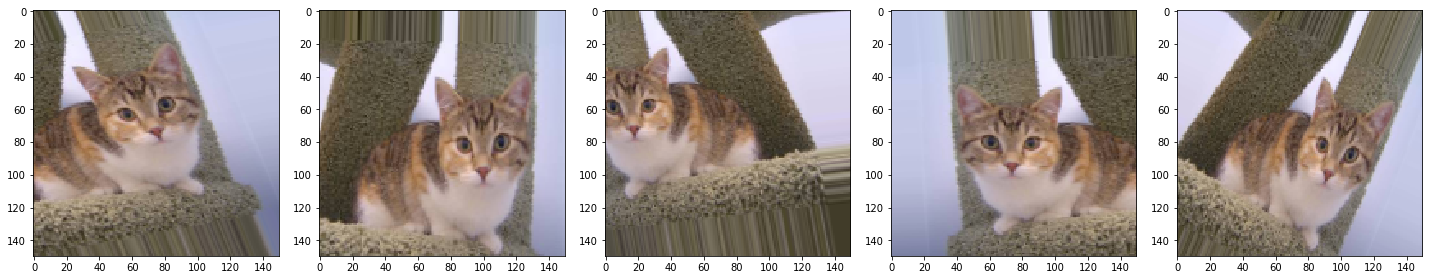

In [82]:
augmented_images = [train_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Validation Data

In [83]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data = image_gen_val.flow_from_directory(directory=validation_dir,
                                        batch_size=BATCH_SIZE,
                                        target_size=(IMG_SHAPE, IMG_SHAPE),
                                        class_mode='binary')

Found 1000 images belonging to 2 classes.


##DNN (structure)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

## DNN (training)

In [87]:
EPOCHS = 100

history = model.fit_generator(
                    train_data,
                    steps_per_epoch=int(np.ceil(total_train/BATCH_SIZE)),
                    epochs=EPOCHS,
                    validation_data = val_data,
                    validation_steps = 10
                              )

Epoch 1/100
20/20 [==============================] - 21s 1s/step - loss: 0.7081 - acc: 0.5055 - val_loss: 0.6959 - val_acc: 0.5000
Epoch 2/100
20/20 [==============================] - 18s 883ms/step - loss: 0.6912 - acc: 0.5235 - val_loss: 0.6802 - val_acc: 0.6030
Epoch 3/100
20/20 [==============================] - 18s 885ms/step - loss: 0.6830 - acc: 0.5650 - val_loss: 0.6964 - val_acc: 0.5010
Epoch 4/100
20/20 [==============================] - 17s 875ms/step - loss: 0.6831 - acc: 0.5415 - val_loss: 0.6891 - val_acc: 0.5240
Epoch 5/100
20/20 [==============================] - 18s 877ms/step - loss: 0.6902 - acc: 0.5020 - val_loss: 0.6496 - val_acc: 0.6120
Epoch 6/100
20/20 [==============================] - 17s 871ms/step - loss: 0.6748 - acc: 0.5615 - val_loss: 0.6389 - val_acc: 0.6390
Epoch 7/100
20/20 [==============================] - 18s 878ms/step - loss: 0.6624 - acc: 0.5765 - val_loss: 0.6374 - val_acc: 0.6160
Epoch 8/100
20/20 [==============================] - 17s 874ms/st

## Visualizing Results

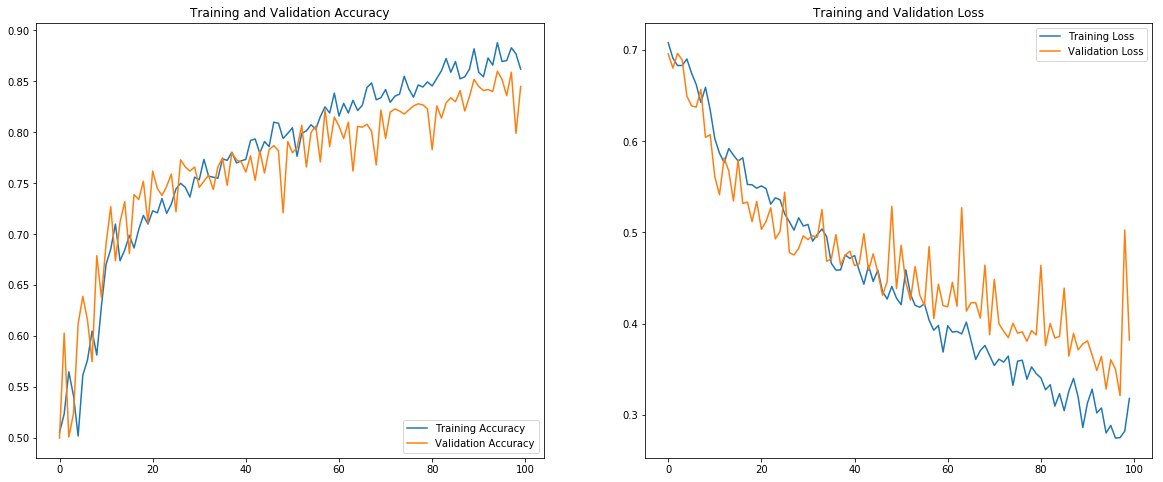

In [88]:
acc       = history.history['acc']
val_acc   = history.history['val_acc']

loss      = history.history['loss']
val_loss  = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./model.png')
plt.show()